In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
%matplotlib inline

### How can I identify similar Marathon performances?

In [2]:
df = pd.read_csv('results.csv')

# Drop row in city where there's a null value
df = df.dropna(subset=['city'])

# Replace values that represent null
df = df.replace('-', np.nan)

# Convert types to numeric
df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']] = df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']].apply(pd.to_numeric)

# Impute null with means
df = df.fillna(df.mean())

In [3]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
# One-Hot encoding
df['gender'] = pd.get_dummies(df.gender, drop_first=True)

# Create features
features = df.drop(['state', 'ctz', 'name', 'city', 'country', 'bib', 'gender', 'division', 'genderdiv', 'overall', 'age', 'official'], 1)

# Define the features and the outcome.
X = features.iloc[:, :9]
y = features.iloc[:, 8]

In [5]:
features.head()

,10k,25k,35k,pace,30k,5k,half,20k,40k
0,17.37,47.67,71.40,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,82.43,116.37,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,45.80,67.42,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,82.43,116.37,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,46.37,67.83,3.10,57.03,8.02,38.60,36.58,76.72


In [6]:
#sns.pairplot(features)

In [7]:
# Create PCAs for all distance interval
x_pca = PCA(2).fit_transform(features)
dfx_pca = pd.DataFrame(data=x_pca, columns=['PCA1', 'PCA2'])
x_pca = dfx_pca.values

dfx_pca.head()

,PCA1,PCA2
0,-259.492392,15.151135
1,-162.990446,2.648166
2,-266.647139,14.782877
3,-162.486957,3.174566
4,-265.340899,14.298981


In [8]:
#sns.pairplot(dfx_pca)

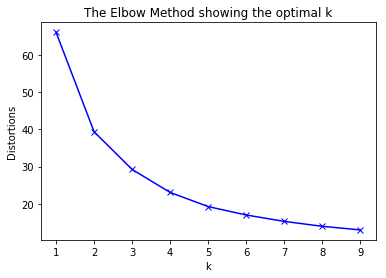

In [9]:
# Create list of distortions for each K value
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(x_pca)
    kmeanModel.fit(x_pca)
    distortions.append(sum(np.min(cdist(x_pca, kmeanModel.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0])

# plot the Elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('The Elbow Method showing the optimal k')
plt.show()

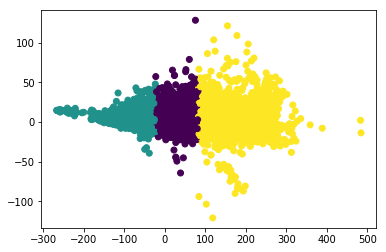

In [10]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(x_pca)

# Plot the solution.
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_pred)
plt.show()

In [11]:
# Labels
# Calculate predicted values.
kmeans = KMeans(n_clusters=3, random_state=42).fit(x_pca)

kmeans.labels_

features['Labels'] = kmeans.labels_

In [12]:
# Value counts
features.Labels.value_counts()

1    14911
0    11897
2     5175
Name: Labels, dtype: int64

In [13]:
features.head()

,10k,25k,35k,pace,30k,5k,half,20k,40k,Labels
0,17.37,47.67,71.40,3.27,59.18,8.02,39.72,37.65,80.43,1
1,32.58,82.43,116.37,5.30,99.33,16.22,69.47,65.83,132.10,1
2,16.62,45.80,67.42,3.08,56.45,7.75,38.03,36.10,76.10,1
3,32.57,82.43,116.37,5.37,99.33,16.20,69.47,65.83,132.95,1
4,17.12,46.37,67.83,3.10,57.03,8.02,38.60,36.58,76.72,1


In [14]:
# Assign independent and dependent variables
x = features.drop(columns=['Labels'])
y = features['Labels']

# Create array of x
x = x.values

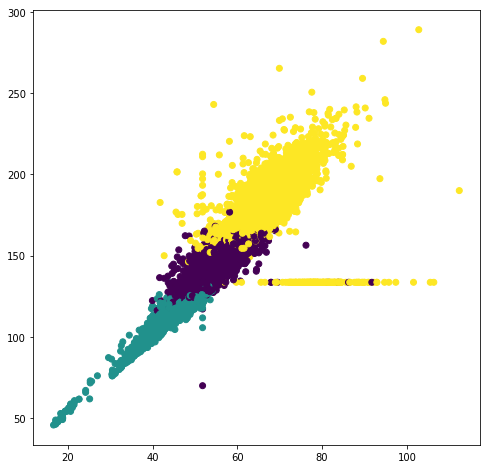

In [15]:
# Plot clusters over scatter plot of features
plt.figure(figsize=(8,8))
plt.scatter(x[:,0], x[:,1], c=y_pred)
plt.show()

<Figure size 576x576 with 0 Axes>

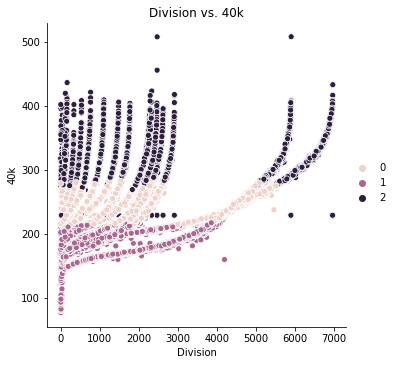

In [29]:
# Division vs 40k
plt.figure(figsize=(8,8))
sns.relplot(x='division', y='40k', data=df, hue=y_pred)
plt.xlabel('Division')
plt.ylabel('40k')
plt.title('Division vs. 40k')
plt.show()

<Figure size 576x576 with 0 Axes>

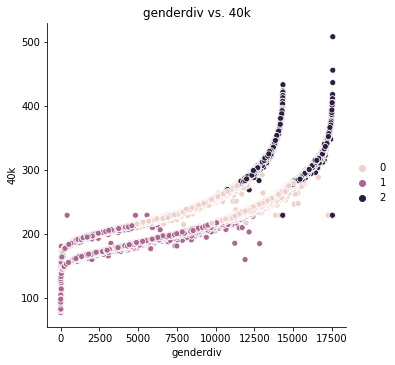

In [30]:
# Genderdiv vs. 40k
plt.figure(figsize=(8,8))
sns.relplot(x='genderdiv', y='40k', data=df, hue=y_pred)
plt.xlabel('genderdiv')
plt.ylabel('40k')
plt.title('genderdiv vs. 40k')
plt.show()

In [18]:
# Assign labels to df
df['Labels'] = kmeans.labels_

# Create dataframe sorted by labels
labels = df.groupby(['Labels']).mean().sort_values(['40k'])

# Create data frame sorting by top 10 countries
country_top_10 = df.groupby(['country']).mean().sort_values(by=['40k']).head(10)

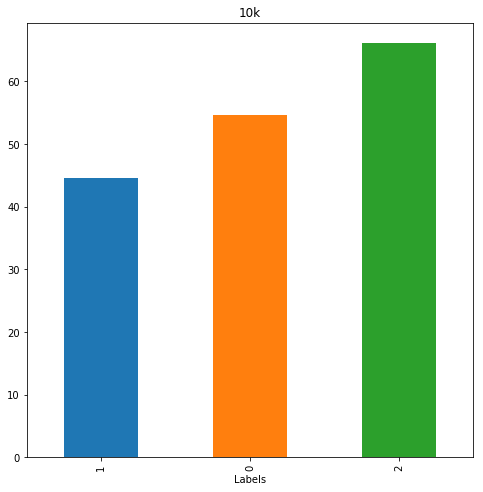

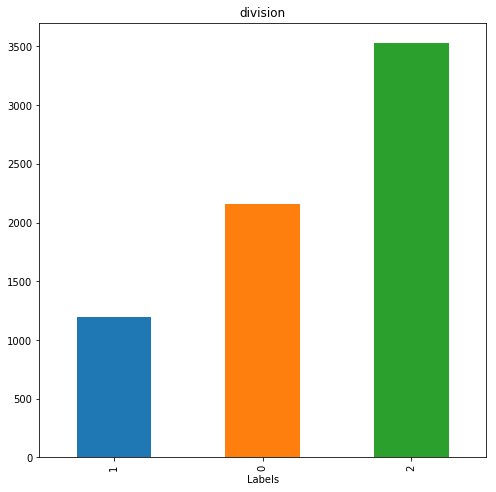

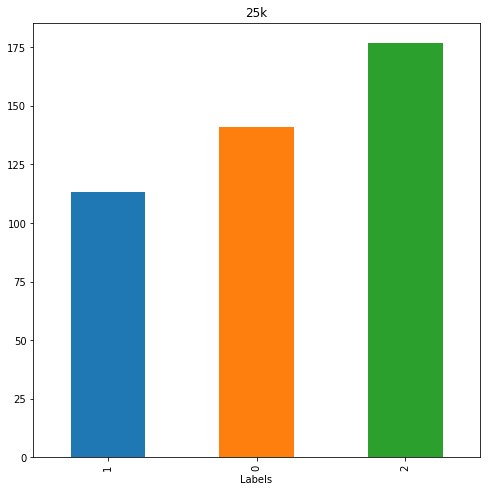

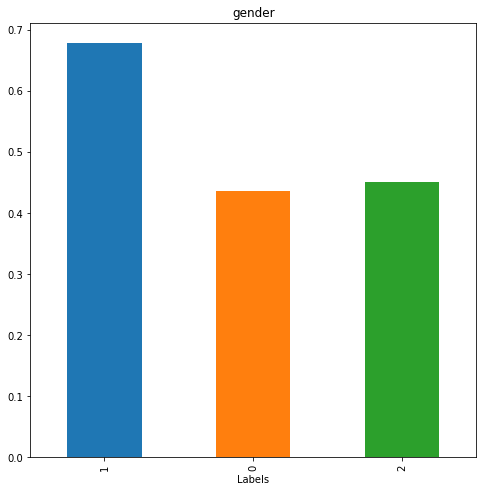

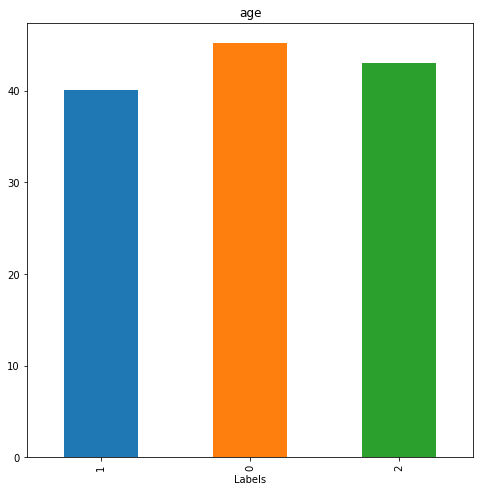

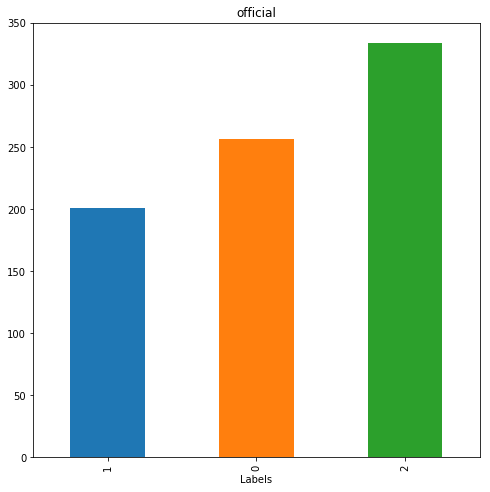

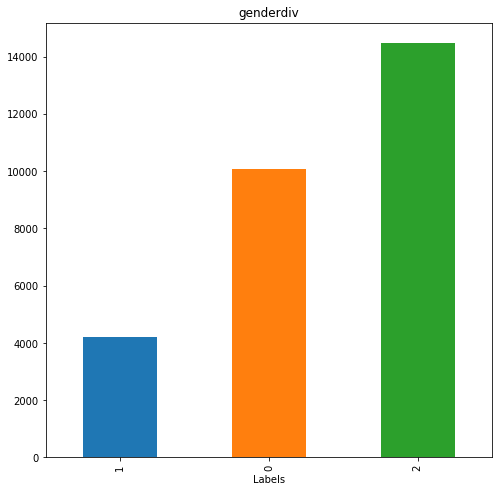

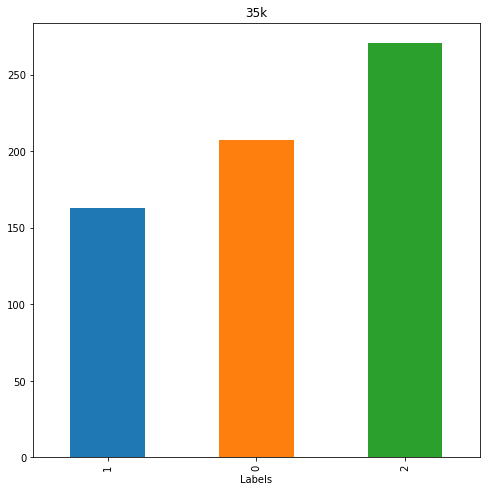

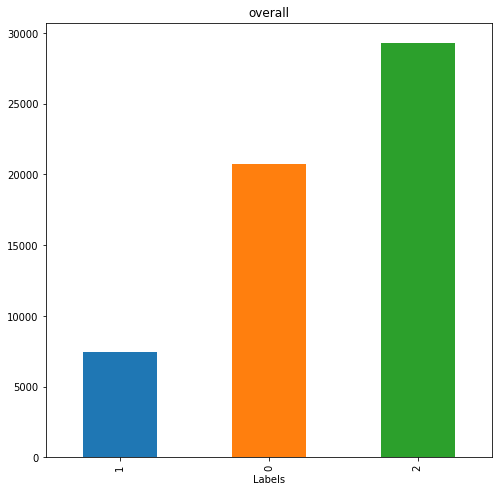

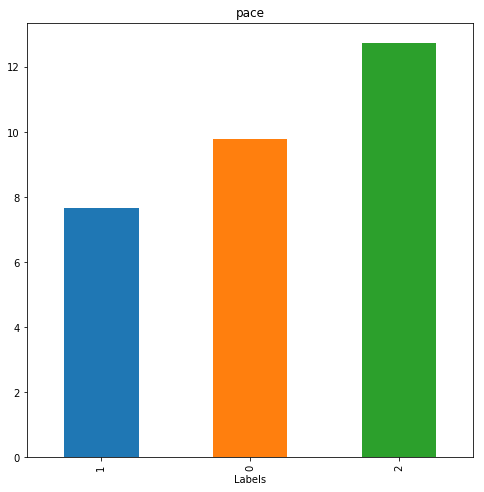

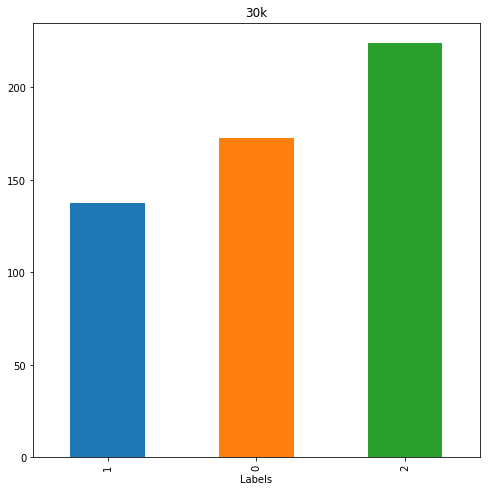

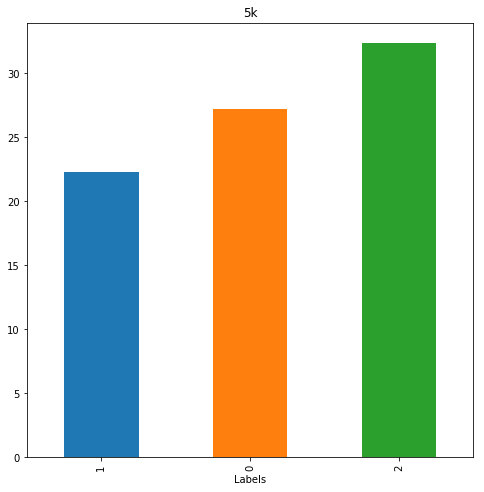

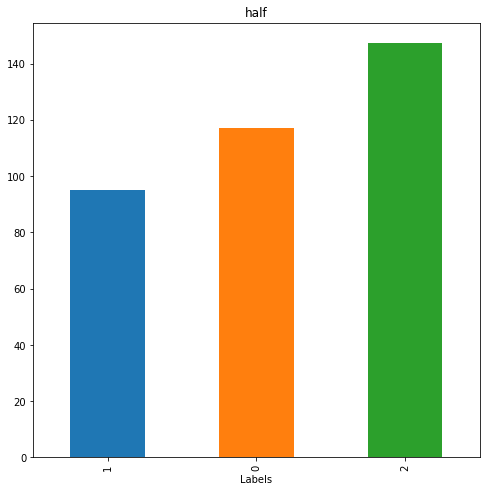

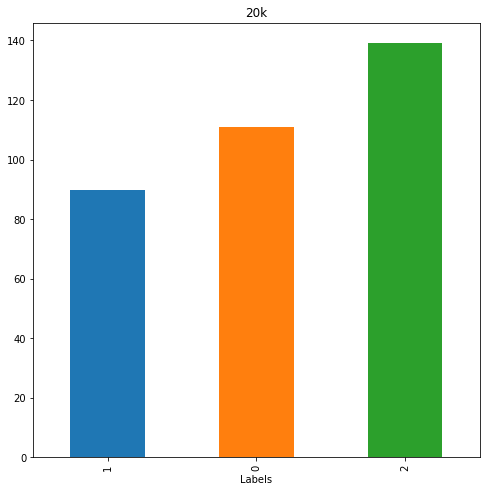

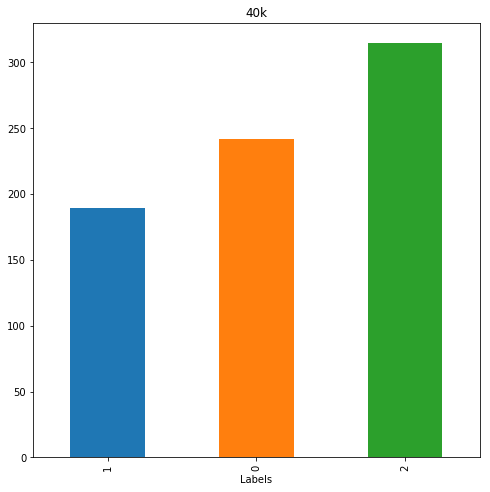

In [21]:
for x in labels.columns:
    plt.figure(figsize=(8,8))
    labels[x].plot.bar()
    plt.title(x)
    plt.show()

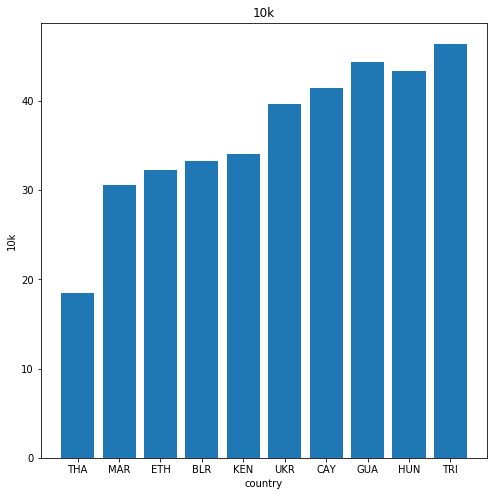

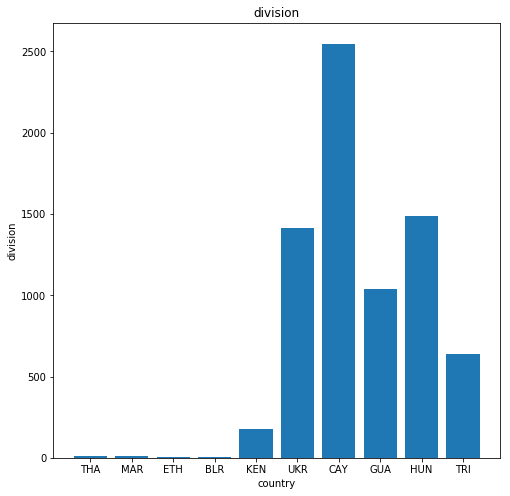

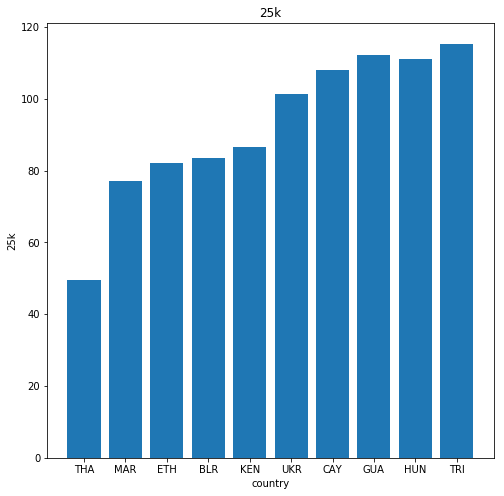

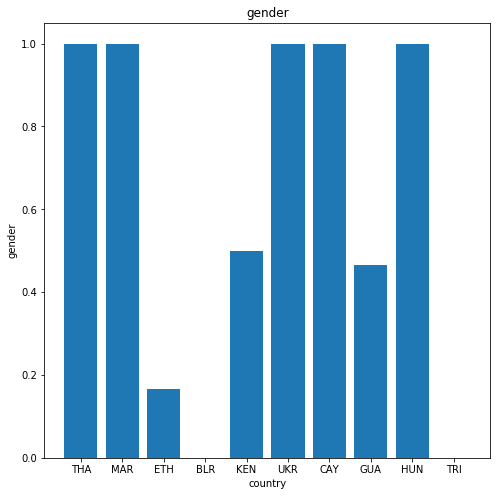

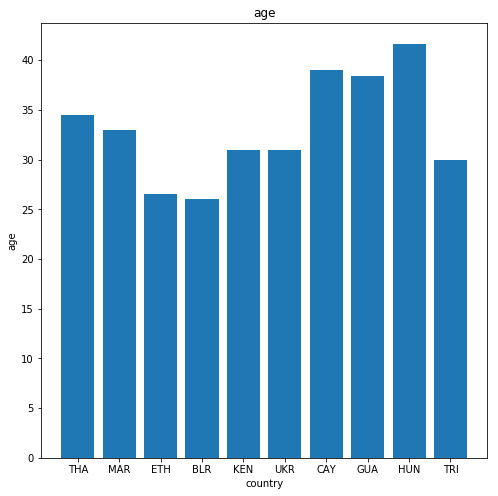

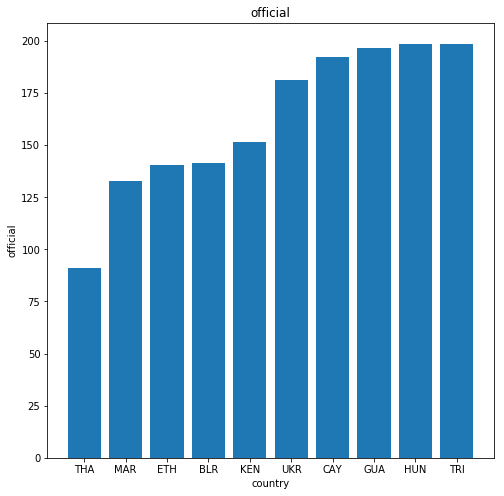

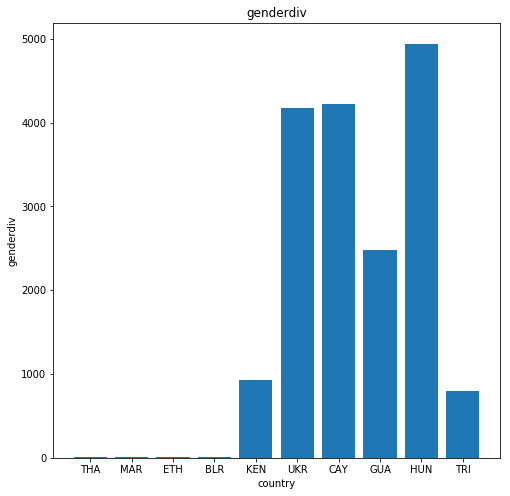

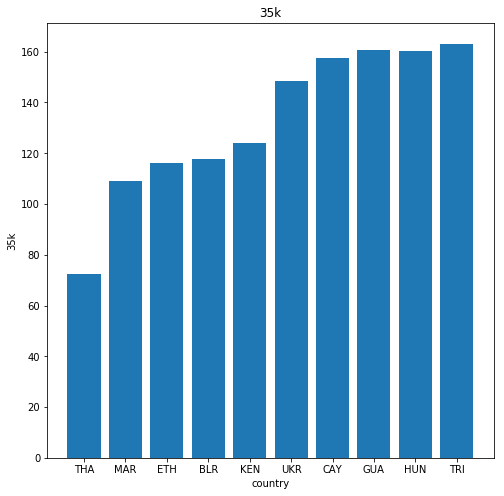

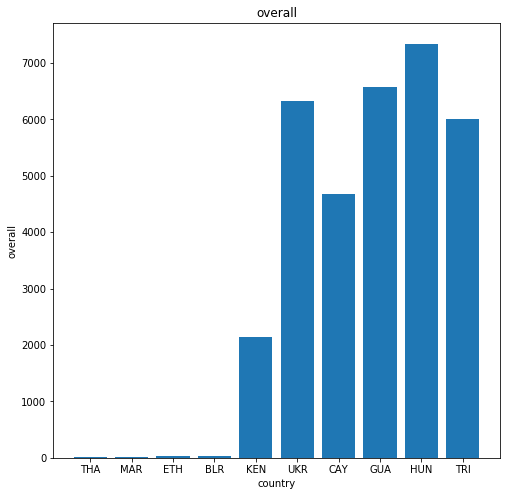

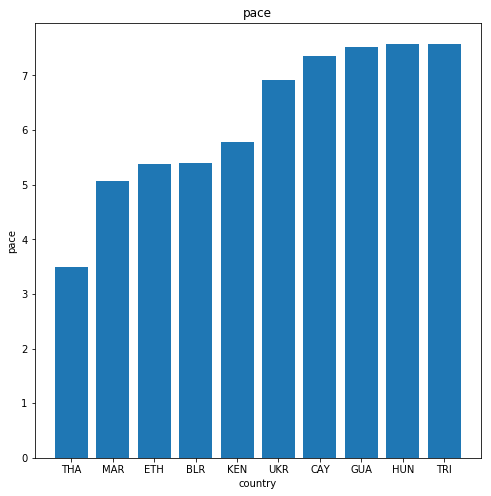

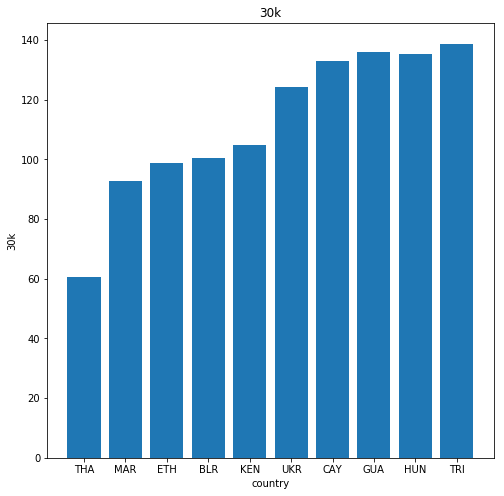

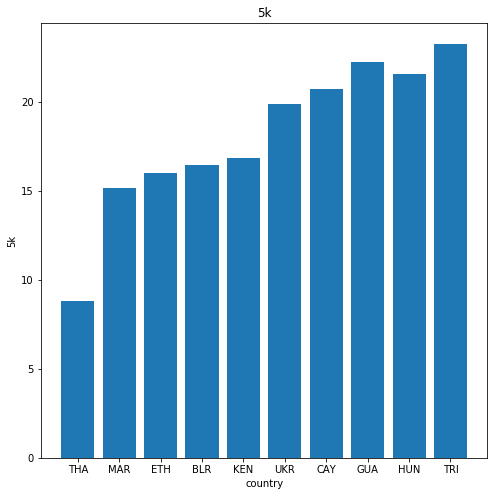

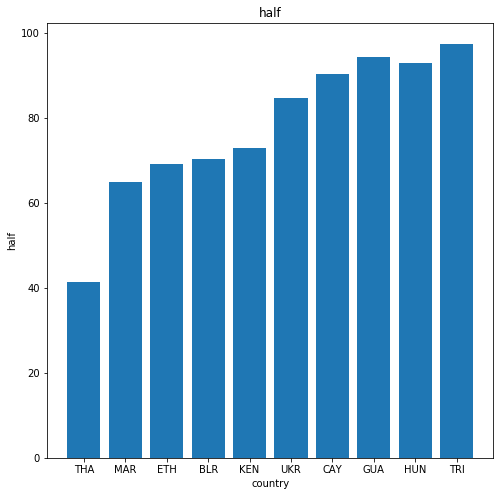

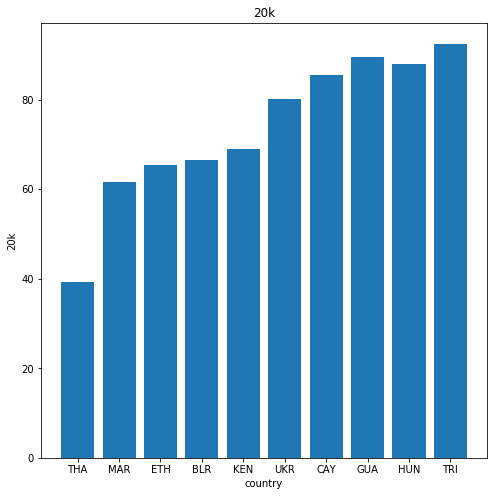

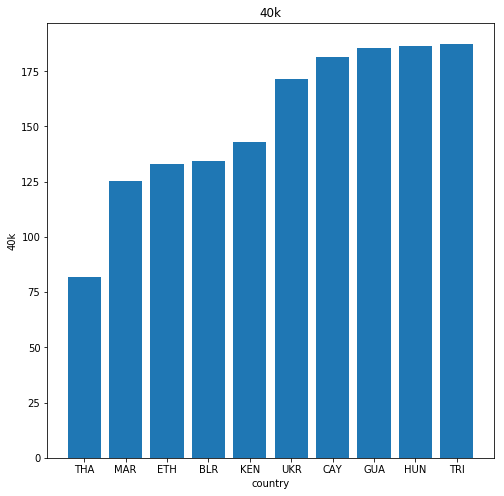

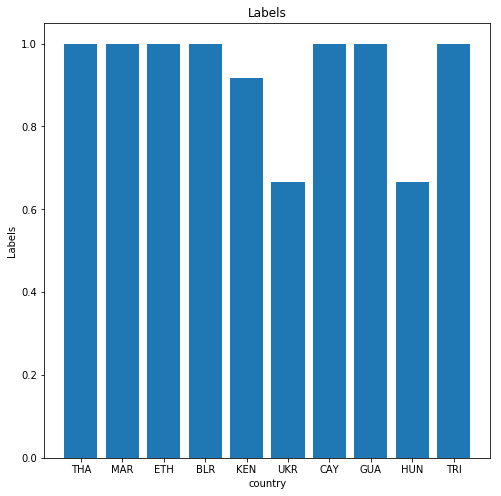

In [22]:
# Mean 40k time per top 10 countries
for x in country_top_10.columns:
    plt.figure(figsize=(8,8))
    plt.bar(country_top_10.index, country_top_10[x])
    plt.xlabel('country')
    plt.ylabel(x)
    plt.title(x)
    plt.show()

In [23]:
labels.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
Labels,,,,,,,,,,,,,,,
1,44.626385,1199.417477,113.050657,0.677553,40.011133,200.744379,4199.442827,163.081681,7482.386560,7.664745,137.423071,22.311233,94.897893,89.923266,189.236958
0,54.576348,2158.206439,140.689260,0.435572,45.159704,256.602823,10088.707826,207.155152,20742.624695,9.794987,172.783826,27.200584,117.223567,111.011265,241.794044
2,66.082926,3526.600386,176.587916,0.450628,42.980290,333.467942,14465.050435,270.506861,29266.211594,12.723486,223.916132,32.357960,147.196478,139.021145,314.170857


In [24]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,pace,state,30k,5k,half,20k,country,city,40k,Labels
0,17.37,"Yamamoto, Hiroyuki",8,47.67,1,47,85.25,W1,8,NaN,...,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43,1
1,32.58,"Jeptoo, Rita",1,82.43,0,33,138.95,F1,1,NaN,...,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10,1
2,16.62,"Van Dyk, Ernst F.",1,45.80,1,41,80.60,W2,1,NaN,...,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10,1
3,32.57,"Dibaba, Mare",3,82.43,0,24,140.58,F2,3,NaN,...,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95,1
4,17.12,"Hokinoue, Kota",2,46.37,1,40,81.23,W3,2,NaN,...,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72,1


In [25]:
features.head()

,10k,25k,35k,pace,30k,5k,half,20k,40k,Labels
0,17.37,47.67,71.40,3.27,59.18,8.02,39.72,37.65,80.43,1
1,32.58,82.43,116.37,5.30,99.33,16.22,69.47,65.83,132.10,1
2,16.62,45.80,67.42,3.08,56.45,7.75,38.03,36.10,76.10,1
3,32.57,82.43,116.37,5.37,99.33,16.20,69.47,65.83,132.95,1
4,17.12,46.37,67.83,3.10,57.03,8.02,38.60,36.58,76.72,1


In [31]:
country_top_10

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,Labels
country,,,,,,,,,,,,,,,,
THA,18.470000,14.000000,49.450000,1.000000,34.500000,91.200000,14.000000,72.400000,14.500000,3.485000,60.670000,8.830000,41.360000,39.210000,82.005000,1.000000
MAR,30.530000,10.000000,76.970000,1.000000,33.000000,132.720000,10.000000,109.150000,10.000000,5.070000,92.600000,15.180000,64.880000,61.630000,125.230000,1.000000
ETH,32.296667,6.333333,81.953333,0.166667,26.500000,140.646667,6.333333,115.961667,34.833333,5.373333,98.833333,16.035000,69.030000,65.426667,132.850000,1.000000
BLR,33.230000,6.000000,83.400000,0.000000,26.000000,141.480000,6.000000,117.650000,34.000000,5.400000,100.580000,16.470000,70.250000,66.570000,134.200000,1.000000
KEN,34.022500,178.833333,86.620000,0.500000,31.000000,151.455833,925.250000,124.015000,2135.583333,5.782500,104.920833,16.868333,72.837500,69.054167,143.082500,0.916667
UKR,39.636667,1415.666667,101.416667,1.000000,31.000000,181.173333,4168.666667,148.406667,6319.333333,6.916667,124.383333,19.900000,84.613333,80.130000,171.356667,0.666667
CAY,41.450000,2548.000000,108.120000,1.000000,39.000000,192.500000,4222.000000,157.650000,4682.000000,7.350000,132.820000,20.720000,90.370000,85.550000,181.600000,1.000000
GUA,44.321333,1038.266667,112.288000,0.466667,38.400000,196.702667,2474.400000,160.648000,6575.000000,7.510667,135.930667,22.240667,94.366000,89.432000,185.560667,1.000000
HUN,43.306667,1489.000000,111.010000,1.000000,41.666667,198.693333,4941.666667,160.223333,7342.000000,7.580000,135.393333,21.576667,92.900000,87.950000,186.466667,0.666667


In [46]:
top_10 = df.sort_values(by ='40k', ascending=True).head(40)
top_10

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,pace,state,30k,5k,half,20k,country,city,40k,Labels
2,16.62,"Van Dyk, Ernst F.",1,45.80,1,41,80.60,W2,1,NaN,...,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10,1
8,17.12,"Soejima, Masazumi",3,46.37,1,43,81.23,W6,3,NaN,...,3.10,NaN,57.03,8.00,38.60,36.60,JPN,Isahaya,76.70,1
4,17.12,"Hokinoue, Kota",2,46.37,1,40,81.23,W3,2,NaN,...,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72,1
6,17.65,"Hug, Marcel E.",4,47.67,1,28,84.65,W4,4,NaN,...,3.23,NaN,58.60,8.38,39.72,37.65,SUI,Neuenkirch,79.83,1
16,17.13,"Madera, Jordi",5,47.45,1,34,84.70,W9,5,NaN,...,3.23,NaN,58.73,8.02,39.12,36.98,ESP,Les Franquesas,79.92,1
30,18.75,"George, Joshua",6,49.15,1,30,84.82,W15,6,NaN,...,3.25,IL,59.92,8.93,41.18,39.08,USA,Champaign,80.18,1
18,18.17,"Hamerlak, Tomasz",7,49.15,1,38,84.88,W10,7,NaN,...,3.25,NaN,59.92,8.67,41.20,39.05,POL,Bystra,80.18,1
0,17.37,"Yamamoto, Hiroyuki",8,47.67,1,47,85.25,W1,8,NaN,...,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43,1
40,17.67,"Senbeta, James",9,48.55,1,27,85.38,W19,9,NaN,...,3.27,IL,59.77,8.38,40.45,38.33,USA,Champaign,80.62,1
56,18.17,"Wahoram, Prawat",18,49.15,1,33,95.50,W25,18,NaN,...,3.65,NaN,60.17,8.68,41.20,39.05,THA,Bangkok,81.83,1


In [49]:
df.columns

Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k',
       'half', '20k', 'country', 'city', '40k', 'Labels'],
      dtype='object')